In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

from scipy.signal import find_peaks

In [2]:
def load_h5_data(file_path, load_meta=True):
    """
    Opens an HDF5 file and returns handles to the datasets.
    """
    try:
        in_file=h5py.File(file_path, "r")
        metadata = {
          "plaintexts": in_file['plaintexts'],
          "key": in_file['key'],
          "masks_rin": in_file['masks_rin'],
          "masks_rout": in_file['masks_rout'],
          "annotations_idcs": in_file['annotations_idcs'],
          "annotations_names": in_file['annotations_names'],
          "prands": in_file['prands'],
          "hashes": in_file['hashes']
        }
        data = {
            "traces": in_file['traces'],
            "labels": in_file['labels']
        }
        if load_meta:
          return data, metadata
        else:
          return data
    except IOError:
        print(f"Error: Can't open HDF5 file '{file_path}' for reading.")
        return None, None

In [3]:
def compute_snr_chunked(traces_h5, labels_h5, byte_index, chunk_size=5000, num_classes=256, epsilon=1e-9):
    """
    Computes SNR in chunks to avoid loading the entire dataset into memory.

    Args:
        traces_h5: The HDF5 dataset object for traces.
        labels_h5: The HDF5 dataset object for labels.
        byte_index: The key byte (0-15) to analyze.
        chunk_size: How many traces to process at a time.
    """
    num_traces, trace_length = traces_h5.shape

    # Initialize arrays to accumulate statistics
    mean = np.zeros((num_classes, trace_length))
    var = np.zeros((num_classes, trace_length))
    cpt = np.zeros(num_classes, dtype=int)

    # Process the data in chunks
    for i in range(0, num_traces, chunk_size):
        # Slice a chunk from the HDF5 file (this is memory-efficient)
        traces_chunk = traces_h5[i:i+chunk_size]
        # Get the labels for the target byte
        labels_chunk = labels_h5[i:i+chunk_size, byte_index]

        # Accumulate statistics for this chunk
        for c in range(num_classes):
            # Find all traces in the chunk that correspond to class 'c'
            class_traces = traces_chunk[labels_chunk == c]
            if class_traces.shape[0] > 0:
                mean[c] += np.sum(class_traces, axis=0)
                var[c] += np.sum(class_traces**2, axis=0)
                cpt[c] += class_traces.shape[0]

    # Calculate the final mean and variance
    for c in range(num_classes):
        if cpt[c] > 0:
            mean[c] /= cpt[c]
            var[c] = (var[c] / cpt[c]) - (mean[c]**2)

    # Avoid division by zero
    var[np.abs(var) < epsilon] = epsilon

    # Calculate the final SNR
    var_of_means = np.var(mean, axis=0)
    mean_of_vars = np.mean(var, axis=0)

    return var_of_means / mean_of_vars

In [4]:
# === Configuration ===

# RANDOM datasets (full random plaintexts)
profiling_random_filepath = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/profiling_mbedtls_masked_20250909_223527.h5"
attack_random_filepath = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_mbedtls_masked_20250909_223527.h5"

# RPA datasets (bytes 0-12 = 0x00, bytes 13-15 = prand)
profiling_rpa_filepath = "/content/drive/MyDrive/mbedtls_synthetic_traces/v2_profiling_mbedtls_masked_20250820_111004.h5"
attack_rpa_filepath = "/content/drive/MyDrive/mbedtls_synthetic_traces/v2_attack_mbedtls_masked_20250820_111004.h5"

# Select which dataset to analyze
USE_RPA = True

if USE_RPA:
    profiling_filepath = profiling_rpa_filepath
    attack_filepath = attack_rpa_filepath
    DATASET_NAME = "RPA"
else:
    profiling_filepath = profiling_random_filepath
    attack_filepath = attack_random_filepath
    DATASET_NAME = "RANDOM"

print(f"Using {DATASET_NAME} dataset: {profiling_filepath}")

Using RPA dataset: /content/drive/MyDrive/mbedtls_synthetic_traces/v2_profiling_mbedtls_masked_20250820_111004.h5


In [6]:
profiling_data, profiling_metadata = load_h5_data(profiling_filepath)
attack_data, attack_metadata = load_h5_data(attack_filepath)

Error: Can't open HDF5 file '/content/drive/MyDrive/mbedtls_synthetic_traces/v2_profiling_mbedtls_masked_20250820_111004.h5' for reading.
Error: Can't open HDF5 file '/content/drive/MyDrive/mbedtls_synthetic_traces/v2_attack_mbedtls_masked_20250820_111004.h5' for reading.


In [ ]:
profiling_traces = profiling_data['traces']
profiling_labels = profiling_data['labels']
anno_idcs = profiling_metadata['annotations_idcs']
anno_names = profiling_metadata['annotations_names']

Computing SNR for Key Byte 0...
Computing SNR for Key Byte 1...
Computing SNR for Key Byte 2...
Computing SNR for Key Byte 3...
Computing SNR for Key Byte 4...
Computing SNR for Key Byte 5...
Computing SNR for Key Byte 6...
Computing SNR for Key Byte 7...
Computing SNR for Key Byte 8...
Computing SNR for Key Byte 9...
Computing SNR for Key Byte 10...
Computing SNR for Key Byte 11...
Computing SNR for Key Byte 12...
Computing SNR for Key Byte 13...
Computing SNR for Key Byte 14...
Computing SNR for Key Byte 15...


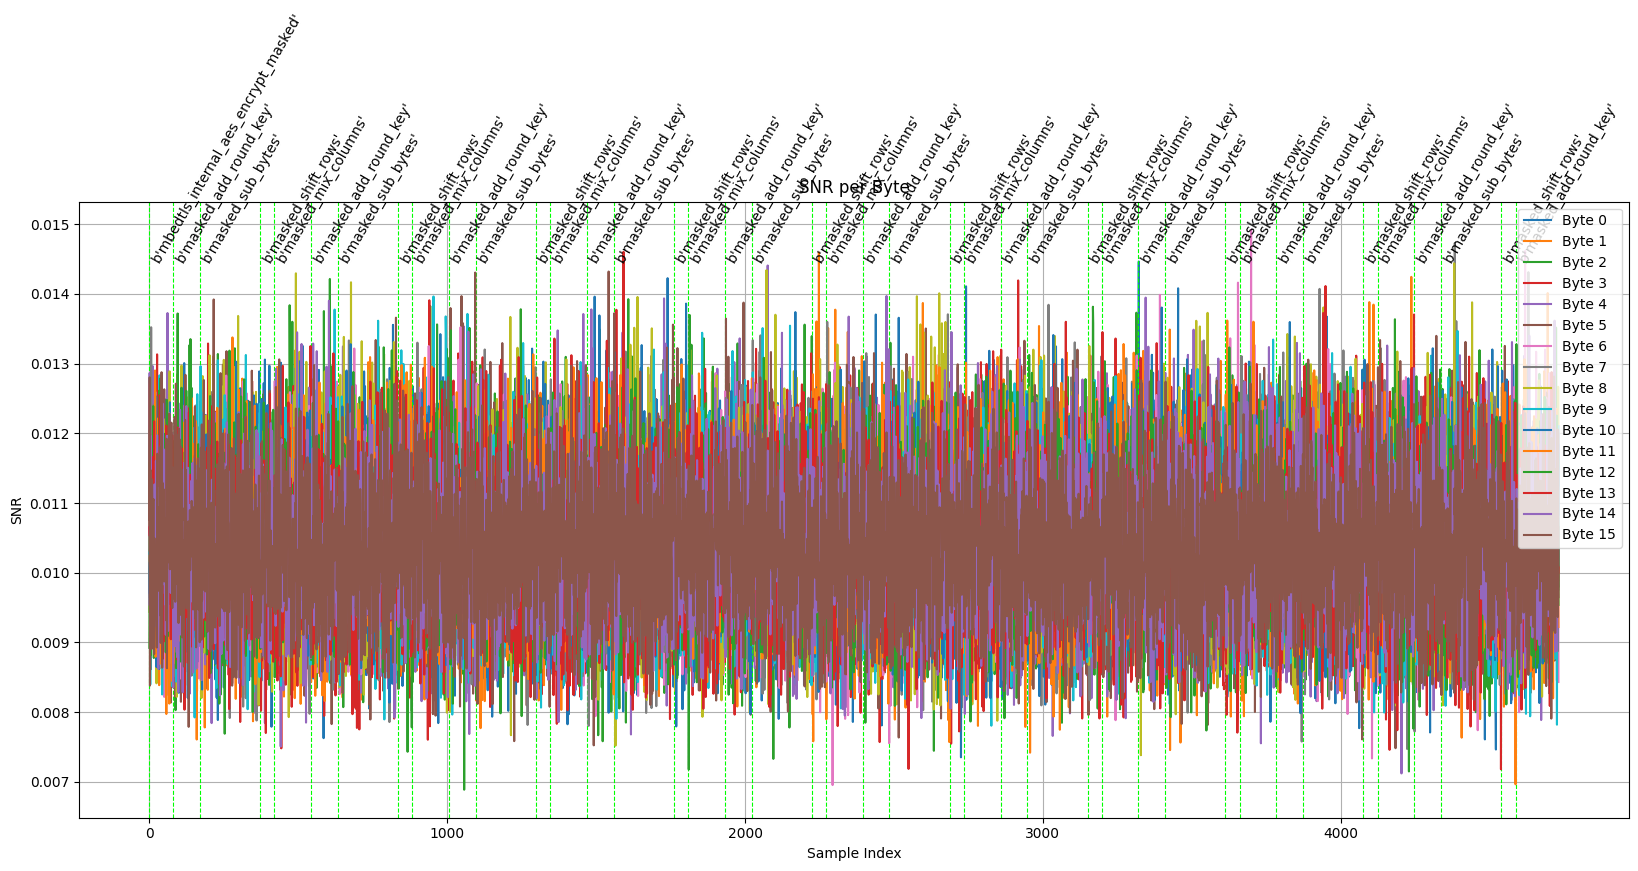

In [ ]:
# Full encryption SNR analysis
# Compare bytes 0-12 (constant PT in RPA) vs bytes 13-15 (variable PT)

plt.figure(figsize=(20, 8))
first_run = True

for byte_index in range(16):
    print(f"Computing SNR for Key Byte {byte_index}...")
    snr_curve = compute_snr_chunked(profiling_traces, profiling_labels, byte_index)
    # Use different colors for bytes 0-12 vs 13-15 to highlight the difference
    color = 'gray' if byte_index < 13 else None
    alpha = 0.5 if byte_index < 13 else 1.0
    linewidth = 0.8 if byte_index < 13 else 1.5
    plt.plot(snr_curve, label=f'Byte {byte_index}', color=color, alpha=alpha, linewidth=linewidth)

    if first_run:
      first_run = False
      for sample_index, function_name in zip(anno_idcs, anno_names):
        # Draw a vertical dashed line at the function's start time
        plt.axvline(x=sample_index, color='lime', linestyle='--', linewidth=0.8)
        # Add a text label for the function name
        plt.text(sample_index, max(snr_curve), function_name, rotation=60)

plt.title(f"SNR per Byte - {DATASET_NAME} Dataset\n(Gray: bytes 0-12, Colored: bytes 13-15)")
plt.xlabel("Sample Index")
plt.ylabel("SNR")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

In [ ]:
def extract_windows(traces, peak_idx, win_radius):
    T, L = traces.shape
    windows = np.zeros((T, 2*win_radius+1))
    for t in range(T):
        start = max(0, peak_idx - win_radius)
        end = min(L, peak_idx + win_radius + 1)
        segment = traces[t, start:end]
        padded = np.zeros(2*win_radius+1)
        padded[:len(segment)] = segment
        windows[t] = padded
    return windows

In [ ]:
#POI processing

def process_all_bytes(data, metadata, output_dir, window_radius=20, top_n_peaks=5):
    os.makedirs(output_dir, exist_ok=True)
    all_peak_locations = {}

    for byte_idx in range(16):
        print(f"Processing byte {byte_idx}")
        snr = compute_snr_chunked(data['traces'], data['labels'], byte_idx)
        peaks, _ = find_peaks(snr, distance=window_radius*2)
        top_peak_indices = np.argsort(snr[peaks])[-top_n_peaks:][::-1]
        top_peaks = peaks[top_peak_indices]
        all_peak_locations[byte_idx] = top_peaks

        # Prepare storage
        with h5py.File(os.path.join(output_dir, f"byte_{byte_idx}.h5"), "w") as outf:
            dst = []
            for pi in top_peaks:
                dst.append(extract_windows(data['traces'], pi, window_radius))
            # shape: (top_n, num_traces, window_length)
            dst = np.stack(dst, axis=1)
            outf.create_dataset("windows", data=dst)
            outf.create_dataset("labels", data=data['labels'][:, byte_idx])
            outf.create_dataset("metadata/plaintexts", data=metadata['plaintexts'][:, byte_idx])
            outf.create_dataset("metadata/key", data=metadata['key'][:, byte_idx])
            outf.create_dataset("metadata/masks_rin", data=metadata['masks_rin'])
            outf.create_dataset("metadata/masks_rout", data=metadata['masks_rout'])
            outf.create_dataset("metadata/annotations_idcs", data=metadata['annotations_idcs'])
            outf.create_dataset("metadata/annotations_names", data=metadata['annotations_names'])
            outf.create_dataset("metadata/prands", data=metadata['prands'])
            outf.create_dataset("metadata/hashes", data=metadata['hashes'])
            outf.create_dataset("metadata/peak_positions", data=top_peaks)
        print(f"[Byte {byte_idx}] saved {len(top_peaks)} windows of size {2*window_radius+1}")
    return all_peak_locations

In [ ]:
# Configure output directory based on dataset type
if USE_RPA:
    PROFILING_WINDOWS_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_profiling_windows"
else:
    PROFILING_WINDOWS_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/profiling_windows"

peaks = process_all_bytes(profiling_data, profiling_metadata, PROFILING_WINDOWS_DIR, window_radius=350)

Processing byte 0
[Byte 0] saved 5 windows of size 701
Processing byte 1
[Byte 1] saved 5 windows of size 701
Processing byte 2
[Byte 2] saved 5 windows of size 701
Processing byte 3
[Byte 3] saved 5 windows of size 701
Processing byte 4
[Byte 4] saved 5 windows of size 701
Processing byte 5
[Byte 5] saved 5 windows of size 701
Processing byte 6
[Byte 6] saved 5 windows of size 701
Processing byte 7
[Byte 7] saved 5 windows of size 701
Processing byte 8
[Byte 8] saved 5 windows of size 701
Processing byte 9
[Byte 9] saved 5 windows of size 701
Processing byte 10
[Byte 10] saved 5 windows of size 701
Processing byte 11
[Byte 11] saved 5 windows of size 701
Processing byte 12
[Byte 12] saved 5 windows of size 701
Processing byte 13
[Byte 13] saved 5 windows of size 701
Processing byte 14
[Byte 14] saved 5 windows of size 701
Processing byte 15
[Byte 15] saved 5 windows of size 701


In [41]:
def process_attack_set(data, metadata, output_dir, profiling_peaks, window_radius=20):
    os.makedirs(output_dir, exist_ok=True)

    for byte_idx in range(16):
        print(f"Processing attack byte {byte_idx}")
        top_peaks = profiling_peaks[byte_idx]

        with h5py.File(os.path.join(output_dir, f"byte_{byte_idx}.h5"), "w") as outf:
            dst = []
            for pi in top_peaks:
                dst.append(extract_windows(data['traces'], pi, window_radius))
            dst = np.stack(dst, axis=1)
            outf.create_dataset("windows", data=dst)
            outf.create_dataset("labels", data=data['labels'][:, byte_idx])
            outf.create_dataset("metadata/plaintexts", data=metadata['plaintexts'][:, byte_idx])
            outf.create_dataset("metadata/key", data=metadata['key'])
            outf.create_dataset("metadata/masks_rin", data=metadata['masks_rin'])
            outf.create_dataset("metadata/masks_rout", data=metadata['masks_rout'])
            outf.create_dataset("metadata/annotations_idcs", data=metadata['annotations_idcs'])
            outf.create_dataset("metadata/annotations_names", data=metadata['annotations_names'])
            outf.create_dataset("metadata/prands", data=metadata['prands'])
            outf.create_dataset("metadata/hashes", data=metadata['hashes'])
            outf.create_dataset("metadata/peak_positions", data=top_peaks)

        print(f"[Attack Byte {byte_idx}] saved {len(top_peaks)} windows of size {2*window_radius+1}")

In [ ]:
# Configure attack output directory based on dataset type
if USE_RPA:
    ATTACK_WINDOWS_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_attack_windows"
else:
    ATTACK_WINDOWS_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_windows"

process_attack_set(attack_data, attack_metadata, ATTACK_WINDOWS_DIR, peaks, window_radius=350)

Processing attack byte 0
[Attack Byte 0] saved 5 windows of size 701
Processing attack byte 1
[Attack Byte 1] saved 5 windows of size 701
Processing attack byte 2
[Attack Byte 2] saved 5 windows of size 701
Processing attack byte 3
[Attack Byte 3] saved 5 windows of size 701
Processing attack byte 4
[Attack Byte 4] saved 5 windows of size 701
Processing attack byte 5
[Attack Byte 5] saved 5 windows of size 701
Processing attack byte 6
[Attack Byte 6] saved 5 windows of size 701
Processing attack byte 7
[Attack Byte 7] saved 5 windows of size 701
Processing attack byte 8
[Attack Byte 8] saved 5 windows of size 701
Processing attack byte 9
[Attack Byte 9] saved 5 windows of size 701
Processing attack byte 10
[Attack Byte 10] saved 5 windows of size 701
Processing attack byte 11
[Attack Byte 11] saved 5 windows of size 701
Processing attack byte 12
[Attack Byte 12] saved 5 windows of size 701
Processing attack byte 13
[Attack Byte 13] saved 5 windows of size 701
Processing attack byte 14


## Sanity checks

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

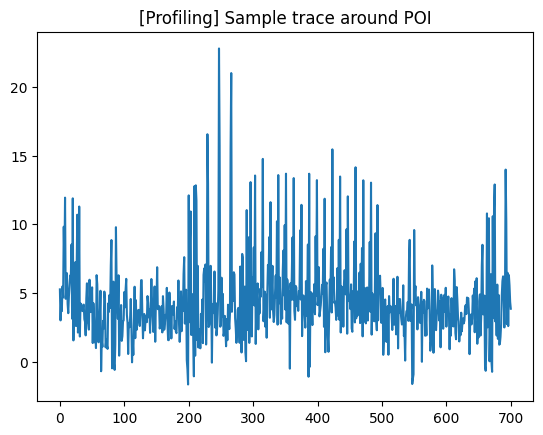

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

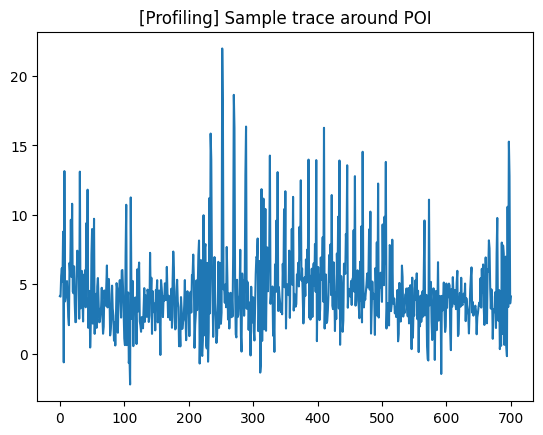

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

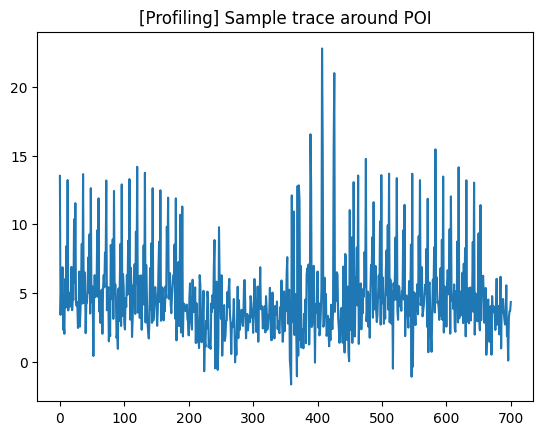

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

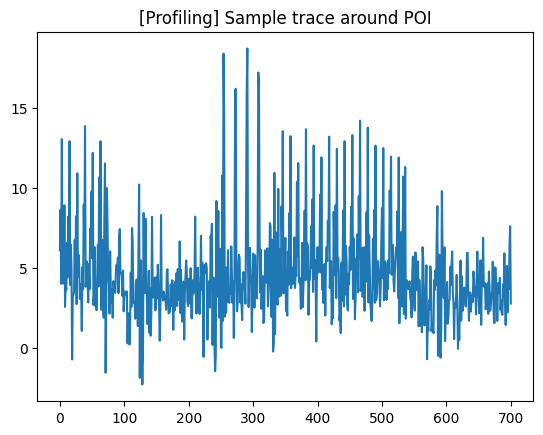

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

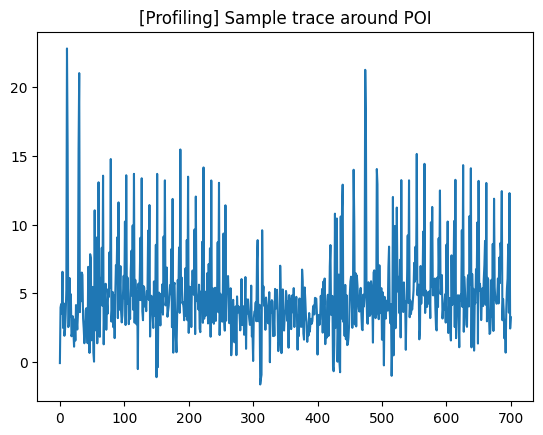

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

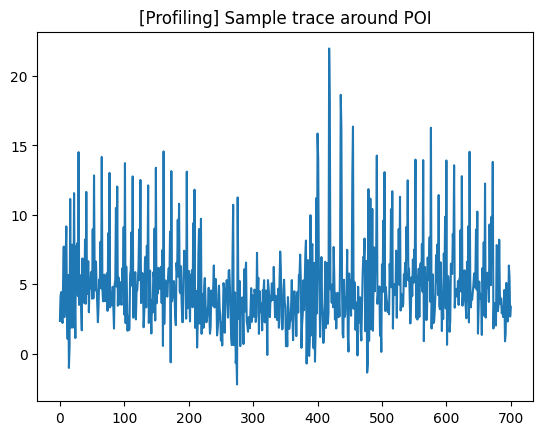

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

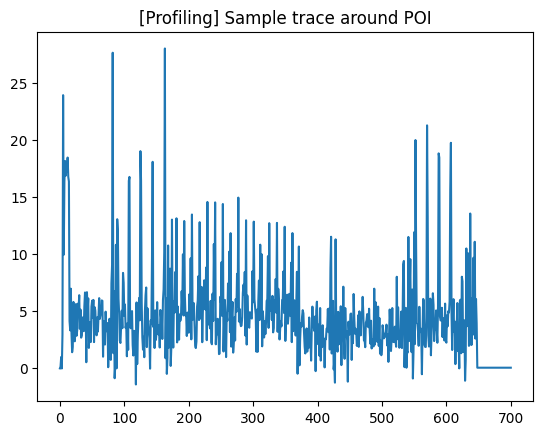

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

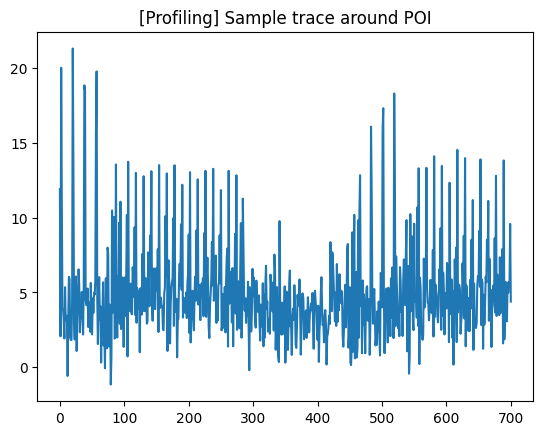

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

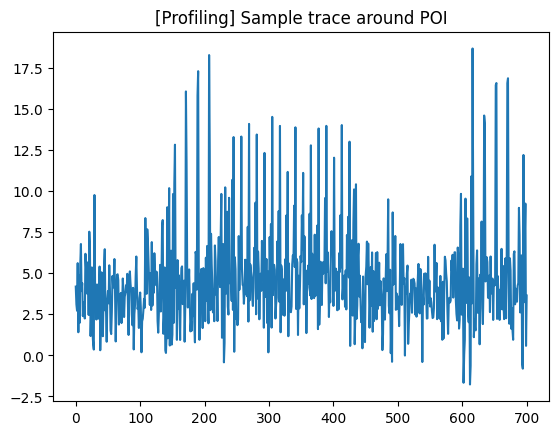

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

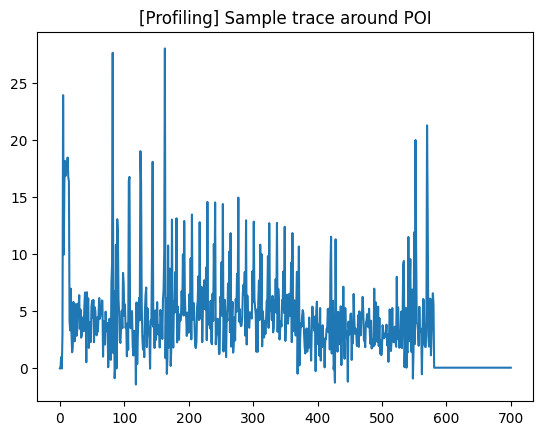

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

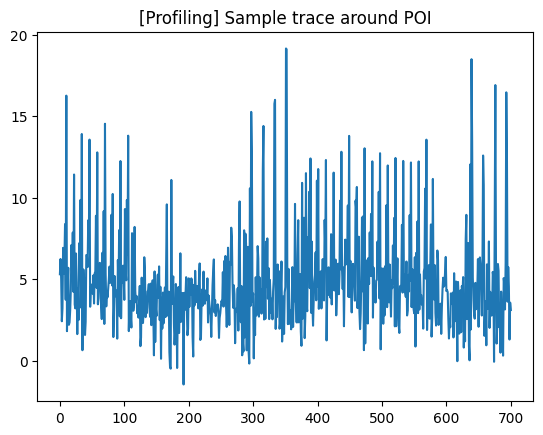

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

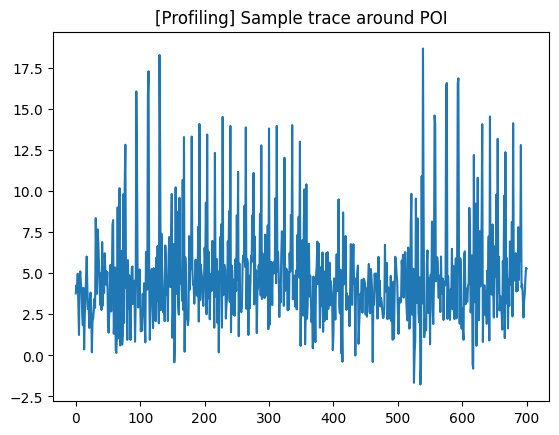

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

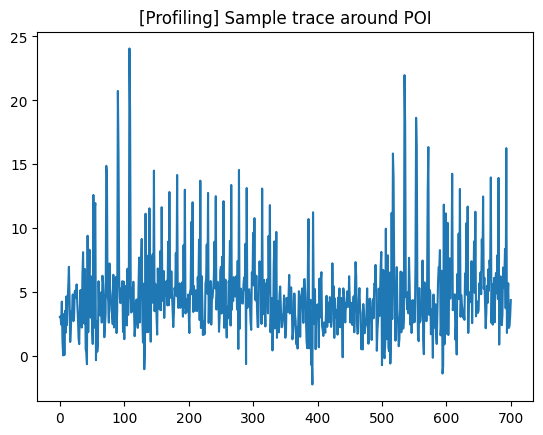

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

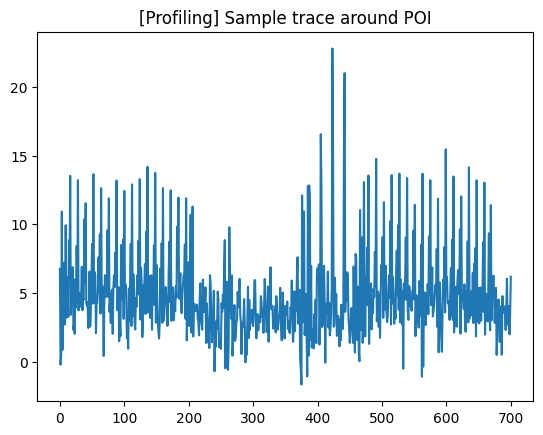

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

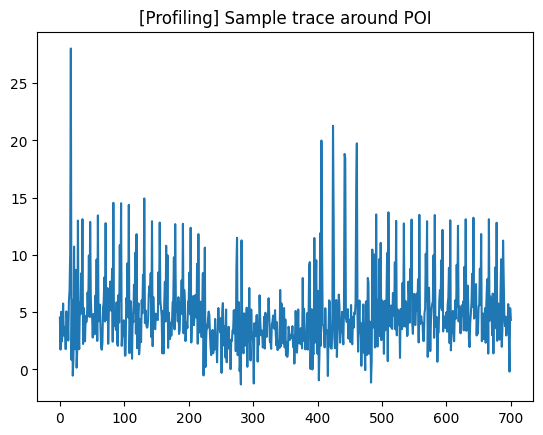

windows shape: (25001, 5, 701)
labels shape: (25001,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

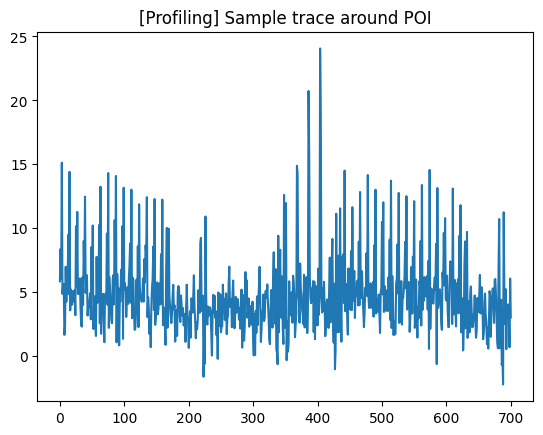

In [ ]:
# Use the configured directories from earlier cells
PROF_WINDOWS_BASE_DIR = PROFILING_WINDOWS_DIR + "/"
ATCK_WINDOWS_BASE_DIR = ATTACK_WINDOWS_DIR + "/"

print(f"Checking {DATASET_NAME} windows:")
print(f"  Profiling: {PROF_WINDOWS_BASE_DIR}")
print(f"  Attack: {ATCK_WINDOWS_BASE_DIR}")

for byte in range(16):

  # check profiling windows
  prof_filepath = os.path.join(PROF_WINDOWS_BASE_DIR, f"byte_{byte}.h5")

  with h5py.File(prof_filepath, "r") as f:
      windows = f['windows'][:]
      labels = f['labels'][:]
      keys = f["metadata/key"][:]
      print(f"\n[Byte {byte}] windows shape:", windows.shape)  # Expect (N, 5, 701)
      print(f"[Byte {byte}] labels shape:", labels.shape)
      print(f"[Byte {byte}] unique labels count:", len(np.unique(labels)))
      print(f"[Byte {byte}] keys shape:", keys.shape)

      plt.plot(windows[0, 0, :])  # first trace, top-1 SNR window
      plt.title(f"[{DATASET_NAME} Profiling] Byte {byte} - Sample trace around POI")
      plt.show()

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

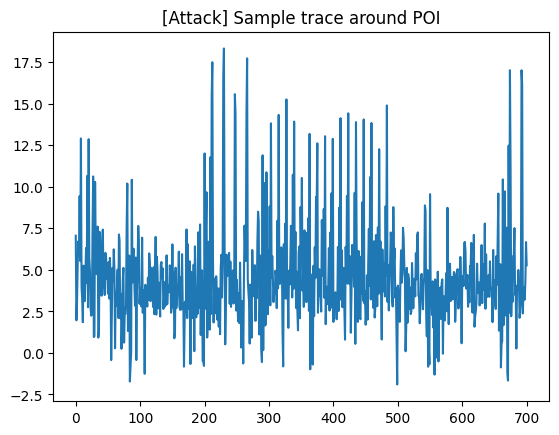

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

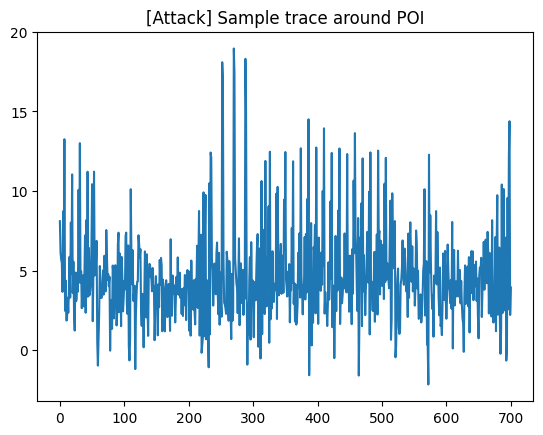

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

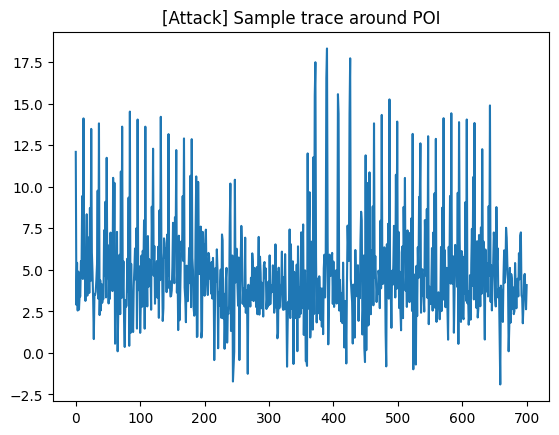

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

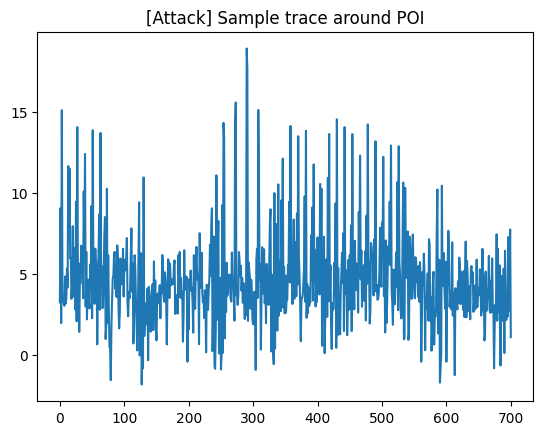

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

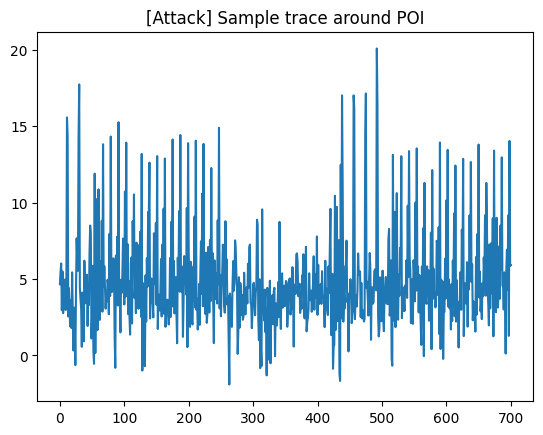

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

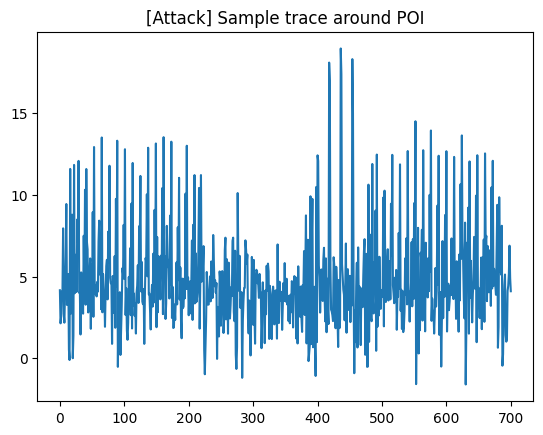

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

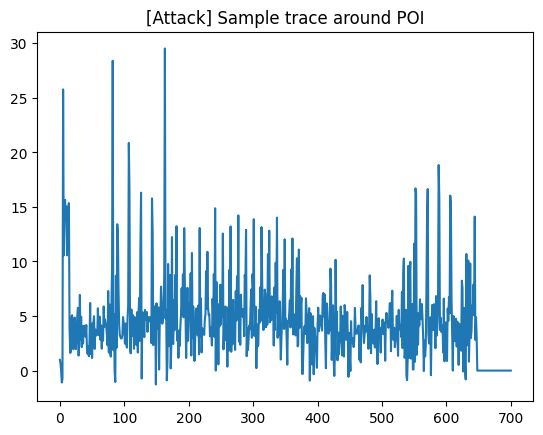

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

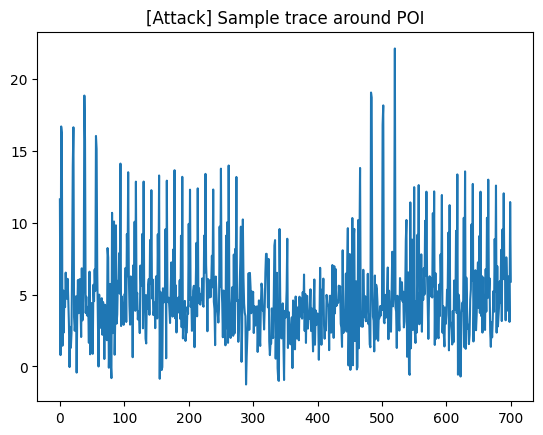

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

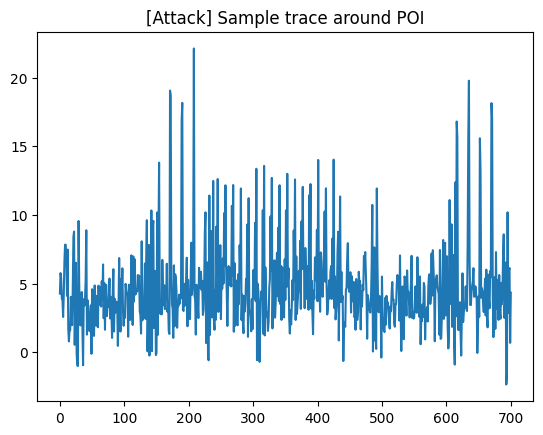

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

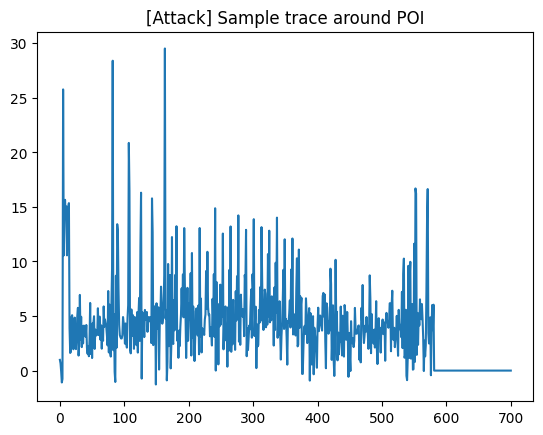

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

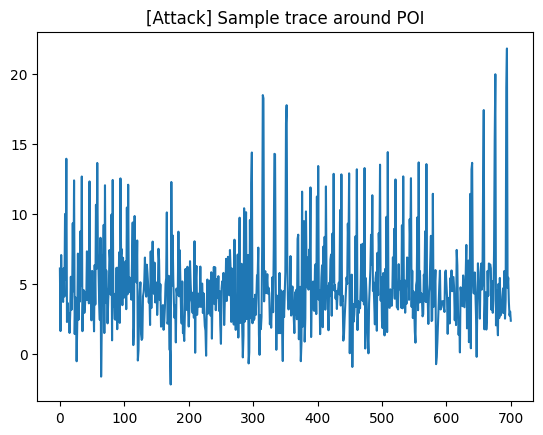

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

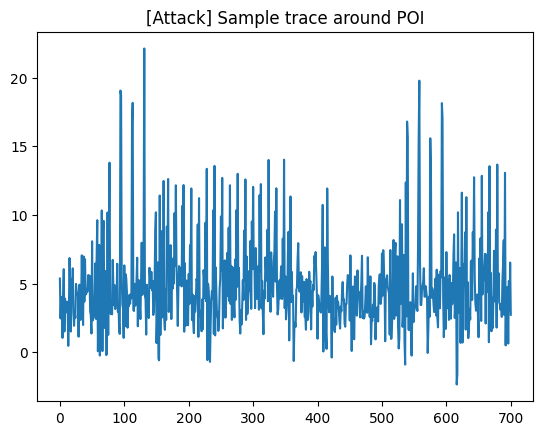

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

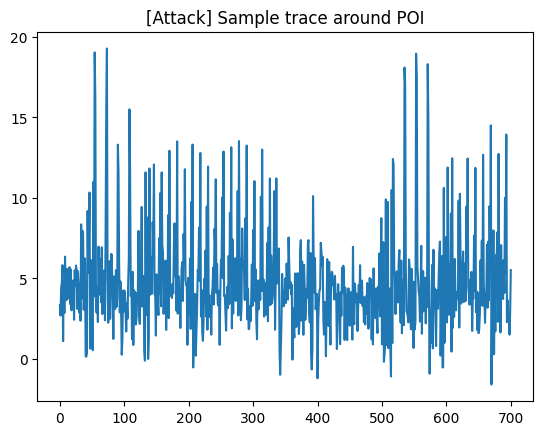

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

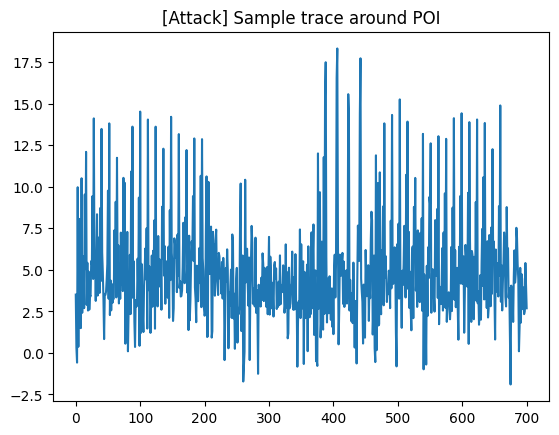

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

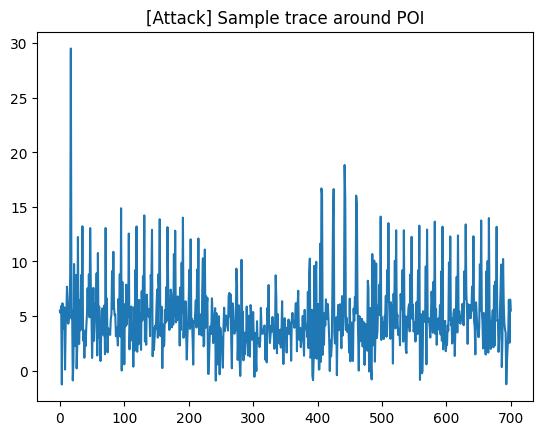

windows shape: (2501, 5, 701)
labels shape: (2501,)
label range: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

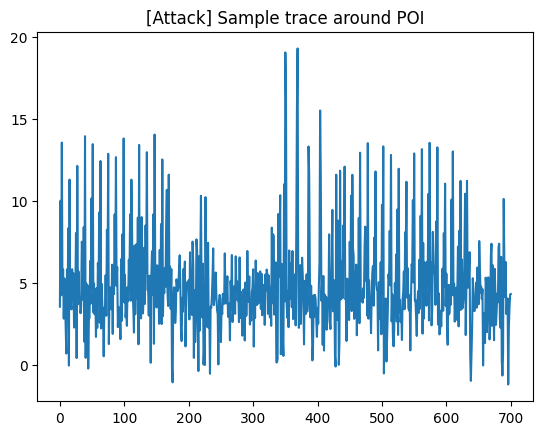

In [44]:
for byte in range(16):
  # check attack windows
  atck_filepath = os.path.join(ATCK_WINDOWS_BASE_DIR, f"byte_{byte}.h5")

  with h5py.File(atck_filepath, "r") as f:
      windows = f['windows'][:]
      labels = f['labels'][:]
      keys = f["metadata/key"][:]
      print("windows shape:", windows.shape)  # Expect (N, 5, 701)
      print("labels shape:", labels.shape)
      print("label range:", np.unique(labels))
      print("keys shape", keys.shape)

      plt.plot(windows[0, 0, :])  # first trace, top-1 SNR window
      plt.title("[Attack] Sample trace around POI")
      plt.show()